### Fig 6: transmission

In [50]:
import sisl
from sisl import *
import sisl.viz
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sisl.viz import merge_plots
from sisl.viz.processors.math import normalize
from functools import partial
# To quickly plot the hamiltonian matrix
import plotly.express as px
import cmath
import scipy
from scipy.linalg import ishermitian
from scipy.linalg import schur, eigvals
from matplotlib.colors import LogNorm
import cmocean


In [51]:
cell = sisl.Geometry(
    [[0, 0, 0], [1, 0, 0]],
    [Atom("C", maxR =1.43420), Atom("C", maxR = 1.43420)],
    lattice=Lattice([2.0, 10, 10], nsc=[3, 1, 1]) #, origin=[-5] * 3
)

https://www.iue.tuwien.ac.at/phd/karamitaheri/node23.html

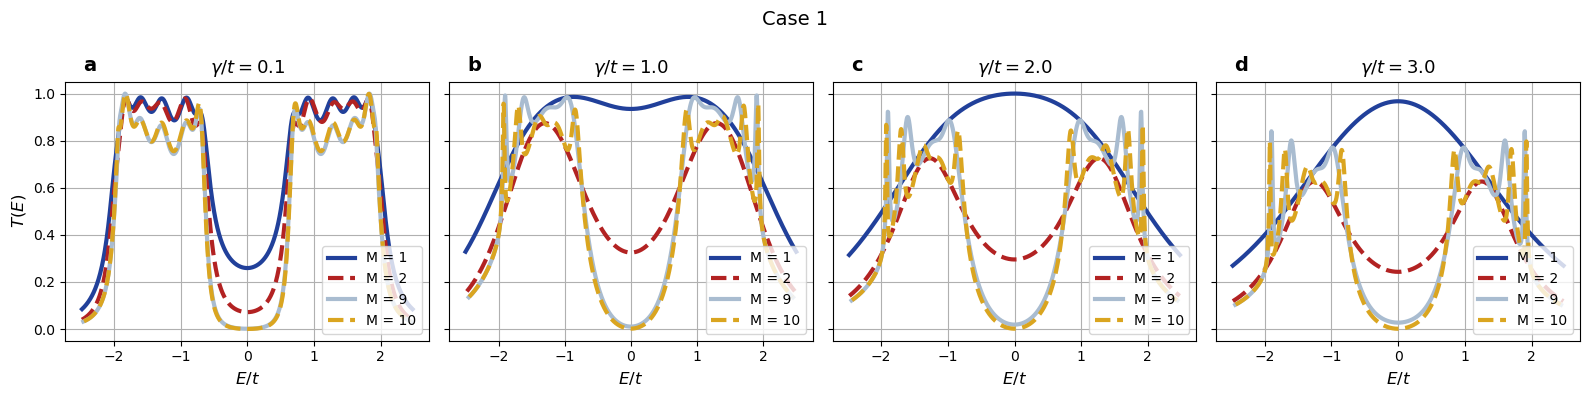

In [ ]:
###############################################################################
# Parameters and Setup
###############################################################################
# System parameters
N   = 10           # number of unit cells
t1  = 4/3
t2  = 2/3

# We'll sweep over four gamma1 values now, including 3.0:
gamma1_values = [0.1, 1.0, 2.0, 3.0]
gamma2        = 1.0  # fixed gamma2 as specified

# We'll also sweep over different M values for decoupling:
M_values = [1, 2, 9, 10]

# For clarity in the plot
markers = ['o', 's', '^', 'D', 'v']  # marker styles
colors  = [
   (33/255, 64/255, 154/255),  # Shay's custom set of cool colors
    'firebrick', 
    '#a9bcd0',
    'goldenrod',
    'mistyrose',
    '#D8DBE2'
]
linestylez = ['-', '--', '-', '--', '-', '--']
#linestylez = ['--', '-', '--', '-', '--']

# Build a minimal geometry for sisl
cell = sisl.Geometry(
    [[0, 0, 0], [1, 0, 0]],
    [Atom("C", maxR=1.43420), Atom("C", maxR=1.43420)],
    lattice=Lattice([2.0, 10, 10], nsc=[3, 1, 1])
)

###############################################################################
# Define a function to build the Hamiltonian and compute T(E)
###############################################################################
def compute_transmission(t1, t2, gamma1_value, gamma2_value, N, M):
    """
    Build the Hamiltonian for the given gamma1, gamma2, N, and M (decoupled sites),
    and compute the transmission T(E) over an energy grid.
    """
    # Build the base 2-site Hamiltonian
    H = sisl.Hamiltonian(cell, dtype='complex')
    H[0, 0] = -1j * gamma1_value
    H[1, 1] = -1j * gamma1_value
    H[0, 1] = t1
    H[1, 0] = t1
    # Next-neighbor hopping
    H[0, 1, (-1, 0)] = t2
    H[1, 0, (1, 0)]  = t2

    # Tile N times along the first dimension
    H1 = H.tile(N, 0)

    # Decouple M sites by removing their onsite terms
    for k in range(2*N - M, 2*N):
        H1[k, k] = 0.0

    # Couple the last site to the tip with gamma2
    H1[2*N - 1, 2*N - 1] = -1j * gamma2_value

    # Convert to a full matrix
    H2 = H1.Hk().toarray()

    # Diagonalize to find a suitable energy window
    eigvals = np.linalg.eigvals(H2)
    e_min   = np.min(eigvals.real) - 0.5
    e_max   = np.max(eigvals.real) + 0.5

    # Construct the energy grid
    ePoints    = 1000
    energyGrid = np.linspace(e_min, e_max, ePoints)

    # Define broadening Gamma1 and Gamma2
    gamma1_array             = np.zeros(2*N)
    gamma1_array[:2*N - M]   = gamma1_value
    gamma1_array[2*N - M:]   = 0.0
    Gamma1                   = 2.0 * np.diag(gamma1_array)

    Gamma2 = np.zeros((2*N, 2*N), dtype=complex)
    Gamma2[2*N - 1, 2*N - 1] = 2.0 * gamma2_value

    # Initialize T(E)
    T_E = np.zeros(ePoints, dtype=float)

    # Compute T(E) = Tr[ Gamma1 G_R Gamma2 G_R^\dagger ]
    for i, E in enumerate(energyGrid):
        denom = (E) * np.eye(2*N, dtype=complex) - H2
        G_R   = np.linalg.inv(denom)
        Gdag  = np.conjugate(G_R.T)

        T_mat = Gamma1 @ G_R @ Gamma2 @ Gdag
        T_E[i] = np.trace(T_mat).real

    return energyGrid, T_E

###############################################################################
# Main calculation loop
###############################################################################
# We'll store results in a nested dictionary for easier plotting:
results = {g1: {} for g1 in gamma1_values}

for g1 in gamma1_values:
    for M in M_values:
        eGrid, T_E = compute_transmission(t1, t2, g1, gamma2, N, M)
        results[g1][M] = (eGrid, T_E)

###############################################################################
# Make the figure with 4 panels (a), (b), (c), (d), one per gamma1
###############################################################################
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
panel_labels = ['a', 'b', 'c', 'd']

for i, g1 in enumerate(gamma1_values):
    ax = axes[i]
    # Plot each M on the same panel with different markers/colors
    for j, M in enumerate(M_values):
        eGrid, T_E = results[g1][M]
        ax.plot(
            eGrid, T_E,
            color=colors[j % len(colors)],
            ls=linestylez[j % len(linestylez)],
            markevery=50,
            label=f"M = {M}",
            lw=3
        )
        
    # Axis labeling and styling
    ax.set_xlabel(r'$E/t$', fontsize=12)
    if i == 0:
        ax.set_ylabel(r'$T(E)$', fontsize=12)
    ax.set_title(fr'$\gamma / t = {g1:.1f}$', fontsize=13)
    ax.text(
        0.05, 1.1, f'{panel_labels[i]}',
        transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left'
    )
    ax.grid(True)
    ax.legend(loc='lower right')
plt.suptitle("Case 1", fontsize=14)
plt.tight_layout()
plt.savefig('transmission_panels_M_triv1.pdf', format='pdf', bbox_inches='tight')
plt.show()


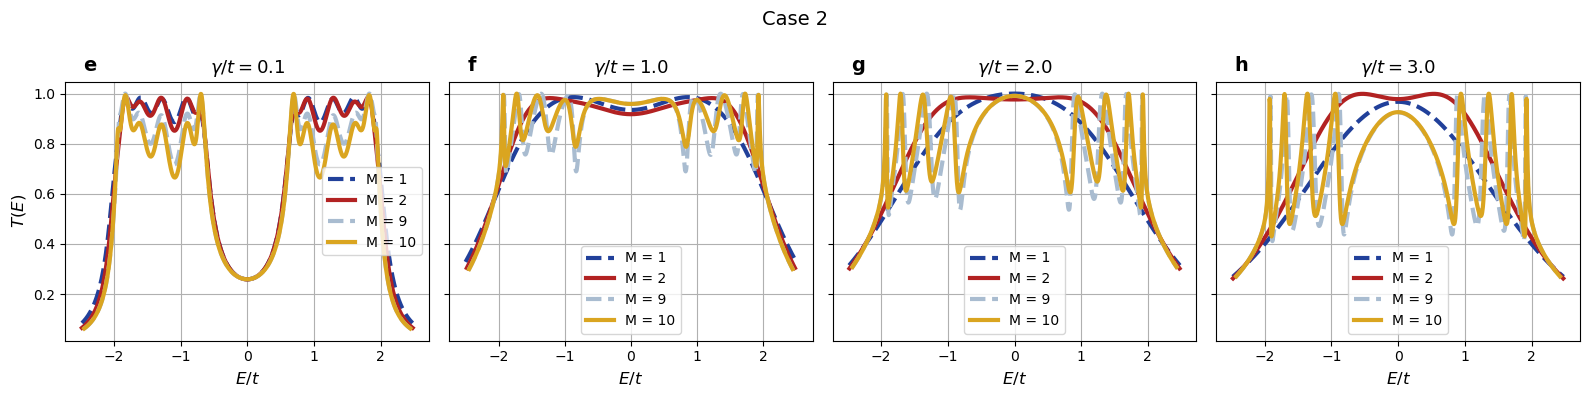

In [53]:
###############################################################################
# Parameters and Setup
###############################################################################
# System parameters
N   = 10           # number of unit cells
t1  = 2/3
t2  = 4/3

# We'll sweep over four gamma1 values now, including 3.0:
gamma1_values = [0.1, 1.0, 2.0, 3.0]
gamma2        = 1.0  # fixed gamma2 as specified

# We'll also sweep over different M values for decoupling:
M_values = [1, 2, 9, 10]

# For clarity in the plot
markers = ['o', 's', '^', 'D', 'v']  # marker styles
colors  = [
   (33/255, 64/255, 154/255),  # Shay's custom set of cool colors
    'firebrick', 
    '#a9bcd0',
    'goldenrod',
    'mistyrose',
    '#D8DBE2'
]
#linestylez = ['-', '--', '-', '--', '-']
linestylez = ['--', '-', '--', '-', '--', '-']

# Build a minimal geometry for sisl
cell = sisl.Geometry(
    [[0, 0, 0], [1, 0, 0]],
    [Atom("C", maxR=1.43420), Atom("C", maxR=1.43420)],
    lattice=Lattice([2.0, 10, 10], nsc=[3, 1, 1])
)

###############################################################################
# Define a function to build the Hamiltonian and compute T(E)
###############################################################################
def compute_transmission(t1, t2, gamma1_value, gamma2_value, N, M):
    """
    Build the Hamiltonian for the given gamma1, gamma2, N, and M (decoupled sites),
    and compute the transmission T(E) over an energy grid.
    """
    # Build the base 2-site Hamiltonian
    H = sisl.Hamiltonian(cell, dtype='complex')
    H[0, 0] = -1j * gamma1_value
    H[1, 1] = -1j * gamma1_value
    H[0, 1] = t1
    H[1, 0] = t1
    # Next-neighbor hopping
    H[0, 1, (-1, 0)] = t2
    H[1, 0, (1, 0)]  = t2

    # Tile N times along the first dimension
    H1 = H.tile(N, 0)

    # Decouple M sites by removing their onsite terms
    for k in range(2*N - M, 2*N):
        H1[k, k] = 0.0

    # Couple the last site to the tip with gamma2
    H1[2*N - 1, 2*N - 1] = -1j * gamma2_value

    # Convert to a full matrix
    H2 = H1.Hk().toarray()

    # Diagonalize to find a suitable energy window
    eigvals = np.linalg.eigvals(H2)
    e_min   = np.min(eigvals.real) - 0.5
    e_max   = np.max(eigvals.real) + 0.5

    # Construct the energy grid
    ePoints    = 1000
    energyGrid = np.linspace(e_min, e_max, ePoints)

    # Define broadening Gamma1 and Gamma2
    gamma1_array             = np.zeros(2*N)
    gamma1_array[:2*N - M]   = gamma1_value
    gamma1_array[2*N - M:]   = 0.0
    Gamma1                   = 2.0 * np.diag(gamma1_array)

    Gamma2 = np.zeros((2*N, 2*N), dtype=complex)
    Gamma2[2*N - 1, 2*N - 1] = 2.0 * gamma2_value

    # Initialize T(E)
    T_E = np.zeros(ePoints, dtype=float)

    # Compute T(E) = Tr[ Gamma1 G_R Gamma2 G_R^\dagger ]
    for i, E in enumerate(energyGrid):
        denom = (E) * np.eye(2*N, dtype=complex) - H2
        G_R   = np.linalg.inv(denom)
        Gdag  = np.conjugate(G_R.T)

        T_mat = Gamma1 @ G_R @ Gamma2 @ Gdag
        T_E[i] = np.trace(T_mat).real

    return energyGrid, T_E

###############################################################################
# Main calculation loop
###############################################################################
# We'll store results in a nested dictionary for easier plotting:
results = {g1: {} for g1 in gamma1_values}

for g1 in gamma1_values:
    for M in M_values:
        eGrid, T_E = compute_transmission(t1, t2, g1, gamma2, N, M)
        results[g1][M] = (eGrid, T_E)

###############################################################################
# Make the figure with 4 panels (e), (f), (g), (h), one per gamma1
###############################################################################
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
panel_labels = ['e', 'f', 'g', 'h']

for i, g1 in enumerate(gamma1_values):
    ax = axes[i]
    # Plot each M on the same panel with different markers/colors
    for j, M in enumerate(M_values):
        eGrid, T_E = results[g1][M]
        ax.plot(
            eGrid, T_E,
            color=colors[j % len(colors)],
            ls=linestylez[j % len(linestylez)],
            markevery=50,
            label=f"M = {M}",
            lw=3
        )
        
    # Axis labeling and styling
    ax.set_xlabel(r'$E/t$', fontsize=12)
    if i == 0:
        ax.set_ylabel(r'$T(E)$', fontsize=12)
    ax.set_title(fr'$\gamma/ t = {g1:.1f}$', fontsize=13)
    ax.text(
        0.05, 1.1, f'{panel_labels[i]}',
        transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left'
    )
    ax.grid(True)

    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.legend(loc='best')
plt.suptitle("Case 2", fontsize=14)
plt.tight_layout()
plt.savefig('transmission_panels_M_nontriv2.pdf', format='pdf', bbox_inches='tight')
plt.show()
